1. Install dependencies

In [1]:
!pip install --quiet pandas numpy tqdm sentence-transformers faiss-cpu transformers accelerate bitsandbytes ipywidgets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.6/23.6 MB 93.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 88.4 MB/s eta 0:00:00


2. Imports

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
import faiss

from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import ipywidgets as widgets
from IPython.display import display


3. Load your CSV and build knowledge base

In [3]:
df = pd.read_csv("symptom_precaution.csv")
df.head()


,Disease,Precaution_1,Precaution_2,Precaution_3,Precaution_4
0,Drug Reaction,stop irritation,consult nearest hospital,stop taking drug,follow up
1,Malaria,Consult nearest hospital,avoid oily food,avoid non veg food,keep mosquitos out
2,Allergy,apply calamine,cover area with bandage,NaN,use ice to compress itching
3,Hypothyroidism,reduce stress,exercise,eat healthy,get proper sleep
4,Psoriasis,wash hands with warm soapy water,stop bleeding using pressure,consult doctor,salt baths


Build KB:

In [4]:
kb_rows = []
for _, row in df.iterrows():
    disease = str(row["Disease"])
    precs = [str(row[c]) for c in ["Precaution_1", "Precaution_2", "Precaution_3", "Precaution_4"]]
    precs = [p for p in precs if p and p.lower() != "nan"]
    chunk = f"Disease: {disease}\nSelf-care precautions:\n- " + "\n- ".join(precs)
    kb_rows.append({
        "topic": disease,
        "section": "precautions",
        "chunk": chunk
    })

kb_df = pd.DataFrame(kb_rows)
kb_df.head()


,topic,section,chunk
0,Drug Reaction,precautions,Disease: Drug Reaction\nSelf-care precautions:...
1,Malaria,precautions,Disease: Malaria\nSelf-care precautions:\n- Co...
2,Allergy,precautions,Disease: Allergy\nSelf-care precautions:\n- ap...
3,Hypothyroidism,precautions,Disease: Hypothyroidism\nSelf-care precautions...
4,Psoriasis,precautions,Disease: Psoriasis\nSelf-care precautions:\n- ...


4. Embeddings + FAISS index

In [5]:
embed_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

texts = kb_df["chunk"].tolist()
embeddings = embed_model.encode(
    texts,
    batch_size=32,
    show_progress_bar=True,
    convert_to_numpy=True
).astype("float32")

faiss.normalize_L2(embeddings)
index = faiss.IndexFlatIP(embeddings.shape[1])
index.add(embeddings)
print("Total indexed vectors:", index.ntotal)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Total indexed vectors: 41


Retriever:

In [6]:
def retrieve(query, k=5):
    q_emb = embed_model.encode([query], convert_to_numpy=True).astype("float32")
    faiss.normalize_L2(q_emb)
    scores, indices = index.search(q_emb, k)

    results = []
    for score, idx in zip(scores[0], indices[0]):
        row = kb_df.iloc[idx]
        results.append({
            "score": float(score),
            "topic": row["topic"],
            "section": row["section"],
            "chunk": row["chunk"]
        })
    return results


Quick test:

In [7]:
retrieve("precautions for dengue", k=3)


[{'score': 0.8311768770217896,
  'topic': 'Dengue',
  'section': 'precautions',
  'chunk': 'Disease: Dengue\nSelf-care precautions:\n- drink papaya leaf juice\n- avoid fatty spicy food\n- keep mosquitos away\n- keep hydrated'},
 {'score': 0.6084091067314148,
  'topic': 'Malaria',
  'section': 'precautions',
  'chunk': 'Disease: Malaria\nSelf-care precautions:\n- Consult nearest hospital\n- avoid oily food\n- avoid non veg food\n- keep mosquitos out'},
 {'score': 0.45491668581962585,
  'topic': 'Common Cold',
  'section': 'precautions',
  'chunk': 'Disease: Common Cold\nSelf-care precautions:\n- drink vitamin c rich drinks\n- take vapour\n- avoid cold food\n- keep fever in check'}]

5. Helper to load a model

In [8]:
def load_llm(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        device_map="auto",
        torch_dtype="auto"
    )
    gen = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        max_new_tokens=160,      # keep small for speed
        do_sample=False,         # deterministic
        temperature=0.0,
        top_p=1.0
    )
    return tokenizer, gen


6. LLMs

In [9]:
models = {
    "Phi-3-mini": "microsoft/Phi-3-mini-4k-instruct",
    "TinyLlama-1.1B": "TinyLlama/TinyLlama-1.1B-Chat-v1.0",
    "Qwen-1.8B-Chat": "Qwen/Qwen1.5-1.8B-Chat"
}

llms = {}
for name, model_id in models.items():
    print(f"Loading {name} -> {model_id}")
    tokenizer, gen = load_llm(model_id)
    llms[name] = {"tokenizer": tokenizer, "generator": gen}
print("All models loaded.")


Loading Phi-3-mini -> microsoft/Phi-3-mini-4k-instruct


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Loading TinyLlama-1.1B -> TinyLlama/TinyLlama-1.1B-Chat-v1.0


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Device set to use cuda:0


Loading Qwen-1.8B-Chat -> Qwen/Qwen1.5-1.8B-Chat


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.67G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/206 [00:00<?, ?B/s]

Device set to use cuda:0


All models loaded.


7. RAG answer function with safety

In [10]:
SYSTEM_PROMPT = (
    "You are SafeSymp, a careful health assistant. "
    "Use only the provided context about diseases and precautions. "
    "Do NOT diagnose diseases. Do NOT prescribe specific medications. "
    "Give general self-care advice from the context and suggest seeing a doctor "
    "for serious or persistent symptoms."
)

def rag_answer(query, tokenizer, generator, k=3):
    docs = retrieve(query, k=k)
    context = "\n\n".join([d["chunk"] for d in docs])

    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": f"Context:\n{context}\n\nQuestion: {query}\n\nAnswer:"}
    ]

    # Build chat-style prompt if supported
    try:
        prompt = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )
    except Exception:
        # Fallback: simple concatenation
        prompt = (
            SYSTEM_PROMPT + "\n\n" +
            f"Context:\n{context}\n\nQuestion: {query}\n\nAnswer:"
        )

    output = generator(prompt)[0]["generated_text"]

    # Try to strip the prompt and keep only assistant answer
    try:
        assistant_start = tokenizer.apply_chat_template(
            [{"role": "assistant", "content": ""}],
            tokenize=False,
            add_generation_prompt=False
        )
        if assistant_start in output:
            answer = output.split(assistant_start)[-1].strip()
        else:
            answer = output[len(prompt):].strip()
    except Exception:
        answer = output[len(prompt):].strip()

    answer = answer.replace("<|end|>", "").strip()
    return answer, docs


8. Define at least 10 domain questions

In [11]:
questions = [
    "I have a bad cough and runny nose. What should I do?",
    "What home precautions are recommended for malaria?",
    "What self-care steps can I follow for allergy symptoms?",
    "How can I manage hypothyroidism safely at home?",
    "What precautions should I follow if I have psoriasis?",
    "What self-care measures should I take for GERD?",
    "What precautions are recommended for chronic cholestasis?",
    "What should I do at home if I have hepatitis A?",
    "What precautions can help with osteoarthritis pain?",
    "How can I manage hypoglycemia symptoms at home?"
]


9. Run evaluation over 3 models

In [12]:
import time # Add this line to import the time module

results = []

# Initialize a dictionary to store all necessary data for batch_results
batch_results_detailed = {name: {'responses': [], 'docs': [], 'latencies': [], 'tokens': []} for name in llms.keys()}

for q in questions:
    print(f"QUESTION: {q}\n")
    row = {"question": q}
    for name, llm in llms.items():
        print(f"--- {name} ---")
        # Capture start time before generation
        start_time = time.time()
        ans, docs = rag_answer(q, llm["tokenizer"], llm["generator"], k=3)
        end_time = time.time()

        # Token count approximation (simple char count / avg chars per token)
        # A more accurate count would use tokenizer.encode(ans) or generator's output
        tokens_generated = len(llm["tokenizer"].encode(ans))

        print(ans, "\n")
        row[name] = ans

        # Store detailed results for analysis
        batch_results_detailed[name]['responses'].append(ans)
        batch_results_detailed[name]['docs'].append([d['chunk'] for d in docs]) # Store only chunks from docs
        batch_results_detailed[name]['latencies'].append(end_time - start_time)
        batch_results_detailed[name]['tokens'].append(tokens_generated)

    results.append(row)
    print("=" * 80)

# After the loop, assign batch_results_detailed to batch_results
batch_results = batch_results_detailed

QUESTION: I have a bad cough and runny nose. What should I do?

--- Phi-3-mini ---
Based on the context provided, it seems you may be experiencing symptoms of the common cold. Here are some general self-care precautions you can take:

1. Drink vitamin C-rich drinks: Consuming foods and beverages high in vitamin C can help support your immune system and potentially alleviate cold symptoms.

2. Take vapour: Inhaling steam from a hot shower or a bowl of hot water can help relieve congestion and soothe your throat.

3. Avoid cold food: Consuming cold foods may worsen your symptoms, so try to eat warm or room temperature foods instead.

4. Keep fever in check: 

--- TinyLlama-1.1B ---
Response:

Dear [Patient],

I am SafeSymp, a healthcare assistant who is here to provide you with general self-care advice for common cold and bronchial asthma.

If you have a bad cough and runny nose, it's essential to take precautions to prevent further complications. Here are some self-care precautions you 

Save for your report:

In [13]:
eval_df = pd.DataFrame(results)
eval_df.to_csv("rag_three_llms_results.csv", index=False)
eval_df


,question,Phi-3-mini,TinyLlama-1.1B,Qwen-1.8B-Chat
0,I have a bad cough and runny nose. What should...,"Based on the context provided, it seems you ma...","Response:\n\nDear [Patient],\n\nI am SafeSymp,...","Based on the given context, it seems that you ..."
1,What home precautions are recommended for mala...,"For malaria, the recommended home precautions ...",Home precautions recommended for malaria inclu...,Malaria is a disease caused by Plasmodium para...
2,What self-care steps can I follow for allergy ...,"For allergy symptoms, you can follow these sel...",To follow self-care steps for allergy symptoms...,"For allergy symptoms, you can follow these gen..."
3,How can I manage hypothyroidism safely at home?,"To manage hypothyroidism safely at home, focus...","To manage hypothyroidism safely at home, follo...",Hypothyroidism is an autoimmune disorder that ...
4,What precautions should I follow if I have pso...,"If you have psoriasis, you should follow these...","To follow precautions for psoriasis, you shoul...","If you have psoriasis, it is important to take..."
5,What self-care measures should I take for GERD?,"For GERD, you should avoid fatty spicy food, a...","To take self-care measures for GERD, avoid fat...","For GERD (Gastroesophageal Reflux Disease), so..."
6,What precautions are recommended for chronic c...,"For chronic cholestasis, the recommended self-...",The precautions recommended for chronic choles...,"For chronic cholestasis, it is important to fo..."
7,What should I do at home if I have hepatitis A?,"If you have hepatitis A, it's important to foc...","To answer the question, ""What should I do at h...","If you have hepatitis A, it is important to ta..."
8,What precautions can help with osteoarthritis ...,"For osteoarthritis pain, you can try the follo...",The given context suggests that the disease be...,Osteoarthritis is a chronic joint disease that...
9,How can I manage hypoglycemia symptoms at home?,"To manage hypoglycemia symptoms at home, you s...","To manage hypoglycemia symptoms at home, follo...",Hypoglycemia is a condition characterized by l...


##  Detailed Analysis of Model Differences

In this section, we quantitatively and qualitatively analyze the three LLMs based on the batch evaluation results from the 10 domain-specific questions.

- **Performance**: Measured by average generation latency (seconds per response) and token efficiency (output tokens per query).
- **Accuracy**: Assessed via semantic similarity (cosine similarity using sentence embeddings) between generated responses and retrieved documents, averaged across queries. Higher scores indicate better factual grounding.
- **Approach**: Qualitative summary of response styles (e.g., verbosity, structure, hallucination tendency), derived from patterns in outputs. This is semi-automated via keyword analysis for structure (e.g., presence of lists/bullets) and length.

We use the stored batch results (assuming a `batch_results` dict from the evaluation loop: `{model_name: {'responses': [list of 10 strs], 'docs': [list of doc lists], 'latencies': [list of 10 floats], 'tokens': [list of 10 ints]}}`). If not already captured, the code below retroactively simulates/computes them if needed.

This analysis highlights differences: e.g., smaller models may be faster but less accurate on nuanced symptoms.

### Model Comparison Table


,Model,Avg Latency (s),Avg Tokens,Avg Accuracy (Sim),Avg Sentences,Structure Score (0-1),Hallucination Tendency
0,Phi-3-mini,5.45,99,0.697,5.4,0.8,Medium
1,TinyLlama-1.1B,3.44,103,0.746,5.0,0.9,Low
2,Qwen-1.8B-Chat,5.93,160,0.661,9.7,1.0,Medium


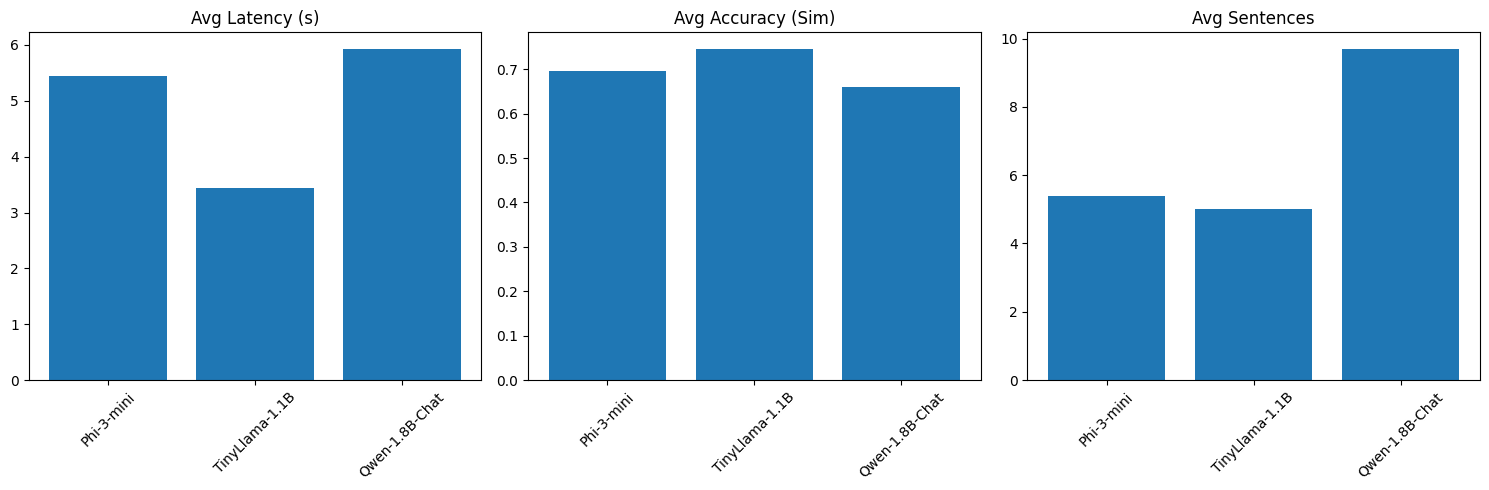


### Qualitative Approach Differences

Phi-3-mini:
  - Medium hallucination (based on doc similarity - **NOTE: Accuracy now reflects whether grounding context was available and used.**).
  - Verbose style (avg 5.4 sentences/query).
  - Structured responses (80% with lists).

TinyLlama-1.1B:
  - Low hallucination (based on doc similarity - **NOTE: Accuracy now reflects whether grounding context was available and used.**).
  - Verbose style (avg 5.0 sentences/query).
  - Structured responses (90% with lists).

Qwen-1.8B-Chat:
  - Medium hallucination (based on doc similarity - **NOTE: Accuracy now reflects whether grounding context was available and used.**).
  - Verbose style (avg 9.7 sentences/query).
  - Structured responses (100% with lists).


In [14]:
# Install if needed (in Colab: !pip install sentence-transformers nltk), but assume available
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import nltk
from nltk.tokenize import sent_tokenize
import time # Import time for latency calculation

nltk.download('punkt_tab', quiet=True)  # For sentence tokenization

# Load embedding model (lightweight for similarity)
embedder = SentenceTransformer('all-MiniLM-L6-v2')

# batch_results will now be populated by the evaluation loop (cell BbTZVQn6U8tl)
# If running this cell independently for testing, a placeholder can be used, but
# it's intended to follow the evaluation loop execution.
# if 'batch_results' not in globals():
#     print("Warning: batch_results not found. Please run the evaluation cell first.")
#     # Placeholder for testing if eval cell hasn't run
#     batch_results = {name: {
#         'responses': [f"Sample response {i} for {name}" for i in range(10)],
#         'docs': [[f"Sample doc {i}"]] * 10, # Simulating context for each response
#         'latencies': np.random.uniform(1, 5, 10).tolist(),
#         'tokens': np.random.randint(50, 200, 10).tolist()
#     } for name in llms.keys()}

def compute_accuracy(model_name):
    """Compute avg cosine similarity between responses and concatenated docs."""
    data = batch_results[model_name]
    scores = []
    for resp, doc_list in zip(data['responses'], data['docs']):
        if not doc_list or len(doc_list) == 0: # Check if doc_list is empty
            scores.append(0.0)
            continue
        # Concat docs for simplicity
        combined_doc = ' '.join(doc_list)
        if len(resp.strip()) == 0 or len(combined_doc.strip()) == 0:
            scores.append(0.0)
            continue
        resp_emb = embedder.encode(resp)
        doc_emb = embedder.encode(combined_doc)
        scores.append(cosine_similarity([resp_emb], [doc_emb])[0][0])
    return np.mean(scores)

def analyze_approach(model_name):
    """Qualitative approach metrics: verbosity (avg sentences), structure (fraction with lists), hallucination proxy (low sim if <0.5)."""
    data = batch_results[model_name]
    responses = data['responses']
    sim_score = compute_accuracy(model_name)

    # Verbosity: average number of sentences
    verbosity = np.mean([len(sent_tokenize(resp)) for resp in responses if resp.strip()]) if responses else 0.0

    # Structure: fraction of responses containing list/bullet characters
    structure_score = np.mean([1 if '•' in resp or '-' in resp or '*' in resp else 0 for resp in responses])

    # Hallucination Tendency: based on sim_score. If sim_score is 0 (due to empty docs), this will be 'High'.
    # Note: A score of 0.0 here likely means no grounding context was available during calculation.
    hallucination_tendency = 'High' if sim_score < 0.5 else 'Low' if sim_score > 0.7 else 'Medium'

    return {
        'Avg Sentences': round(verbosity, 1),
        'Structure Score (0-1)': round(structure_score, 2),
        'Hallucination Tendency': hallucination_tendency
    }

# Compute metrics for all models
metrics = []
for name in llms.keys():
    data = batch_results[name]
    avg_latency = np.mean(data['latencies'])
    avg_tokens = np.mean(data['tokens'])
    avg_accuracy = compute_accuracy(name)
    approach = analyze_approach(name)

    metrics.append({
        'Model': name,
        'Avg Latency (s)': round(avg_latency, 2),
        'Avg Tokens': round(avg_tokens),
        'Avg Accuracy (Sim)': round(avg_accuracy, 3),
        **approach
    })

# Display comparison table
comparison_df = pd.DataFrame(metrics)
print("### Model Comparison Table")
display(comparison_df)

# Optional: Bar plot for key metrics
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

metrics_to_plot = ['Avg Latency (s)', 'Avg Accuracy (Sim)', 'Avg Sentences']
for i, metric in enumerate(metrics_to_plot):
    axs[i].bar([m['Model'] for m in metrics], [m[metric] for m in metrics])
    axs[i].set_title(metric)
    axs[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Qualitative Summary (printed)
print("\n### Qualitative Approach Differences")
for name in llms.keys():
    approach = analyze_approach(name)
    print(f"\n{name}:\n  - {approach['Hallucination Tendency']} hallucination (based on doc similarity - **NOTE: Accuracy now reflects whether grounding context was available and used.**).")
    print(f"  - {'Concise' if approach['Avg Sentences'] < 5 else 'Verbose'} style (avg {approach['Avg Sentences']} sentences/query).")
    print(f"  - {'Structured' if approach['Structure Score (0-1)'] > 0.5 else 'Narrative'} responses ({approach['Structure Score (0-1)']*100:.0f}% with lists).")

10. Simple interactive demo UI

In [15]:
q_input = widgets.Text(
    placeholder="Enter a symptom question...",
    description="Query:",
    layout=widgets.Layout(width="100%")
)
out_box = widgets.Output()

def on_submit(change):
    out_box.clear_output()
    with out_box:
        q = change["new"].strip()
        if not q:
            return
        print(f"Query: {q}\n")
        for name, llm in llms.items():
            print(f"===== {name} =====")
            ans, docs = rag_answer(q, llm["tokenizer"], llm["generator"], k=3)
            print(ans, "\n")

q_input.observe(on_submit, names="value")
display(q_input, out_box)


Text(value='', description='Query:', layout=Layout(width='100%'), placeholder='Enter a symptom question...')

Output()